In [1]:
import pandas as pd
import numpy as np
import os
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold

print("✅ 1. Necessary libraries imported.")

✅ 1. Necessary libraries imported.


In [2]:
# --- Configuration ---
DATA_FOLDER = "GBC data"  # Relative path to your data folder
X_TRAIN_FILE = os.path.join(DATA_FOLDER, "train_features.xlsx")
Y_TRAIN_FILE = os.path.join(DATA_FOLDER, "train_labels.xlsx")
X_TEST_FILE = os.path.join(DATA_FOLDER, "test_features.xlsx")
Y_TEST_FILE = os.path.join(DATA_FOLDER, "test_labels.xlsx")

MODEL_OUTPUT_PATH = "gradient_boosting_model_best.pkl" # Relative output path

# --- Load Data ---
try:
    X_train_df = pd.read_excel(X_TRAIN_FILE)
    y_train_df = pd.read_excel(Y_TRAIN_FILE)
    X_test_df = pd.read_excel(X_TEST_FILE)
    y_test_df = pd.read_excel(Y_TEST_FILE)
    
    print("✅ 2. All data files loaded successfully.")
    print(f"   - X_train shape: {X_train_df.shape}")
    print(f"   - y_train shape: {y_train_df.shape}")
    print(f"   - X_test shape:  {X_test_df.shape}")
    print(f"   - y_test shape:  {y_test_df.shape}")

except FileNotFoundError as e:
    print(f"❌ Error loading file: {e}")
    print("Please make sure the 'GBC data' folder is in the same directory as this notebook.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

✅ 2. All data files loaded successfully.
   - X_train shape: (5649, 4)
   - y_train shape: (5649, 4)
   - X_test shape:  (1414, 4)
   - y_test shape:  (1414, 4)


In [3]:
# Check if data was loaded before processing
if 'X_train_df' in locals():
    # --- 1. Convert labels from one-hot to class indices ---
    # np.argmax finds the index of the '1' in each row
    y_train = np.argmax(y_train_df.values, axis=1)
    y_test = np.argmax(y_test_df.values, axis=1)
    print("Labels converted from one-hot to class indices.")

    # --- 2. Group data every 7 rows ---
    # The original script assumes a 7-row window
    WINDOW_SIZE = 7

    # Group X_train: flatten 7 rows of features into one long vector
    X_train_grouped = [X_train_df.iloc[i:i+WINDOW_SIZE].values.flatten() 
                       for i in range(0, len(X_train_df), WINDOW_SIZE)]
    # Group y_train: take the label corresponding to the *last* row of the window
    y_train_grouped = [y_train[i + WINDOW_SIZE - 1] 
                       for i in range(0, len(y_train), WINDOW_SIZE)]

    # Repeat for test data
    X_test_grouped = [X_test_df.iloc[i:i+WINDOW_SIZE].values.flatten() 
                      for i in range(0, len(X_test_df), WINDOW_SIZE)]
    y_test_grouped = [y_test[i + WINDOW_SIZE - 1] 
                      for i in range(0, len(y_test), WINDOW_SIZE)]

    # --- 3. Convert lists to NumPy arrays for scikit-learn ---
    X_train = np.array(X_train_grouped)
    y_train = np.array(y_train_grouped)
    X_test = np.array(X_test_grouped)
    y_test = np.array(y_test_grouped)

    print("\nData preprocessing (grouping) complete.")
    print(f"   - New X_train shape: {X_train.shape}")
    print(f"   - New y_train shape: {y_train.shape}")
    print(f"   - New X_test shape:  {X_test.shape}")
    print(f"   - New y_test shape:  {y_test.shape}")
    print("\n✅ 3. Data successfully preprocessed for GBC model.")
else:
    print("❌ 3. Data processing skipped because data was not loaded in Cell 2.")

Labels converted from one-hot to class indices.

Data preprocessing (grouping) complete.
   - New X_train shape: (807, 28)
   - New y_train shape: (807,)
   - New X_test shape:  (202, 28)
   - New y_test shape:  (202,)

✅ 3. Data successfully preprocessed for GBC model.


In [4]:
# --- 1. Create the Gradient Boosting model ---
gradient_boosting = GradientBoostingClassifier(random_state=42)

# --- 2. Define the parameter grid for searching ---
param_grid = {
    'n_estimators': [70, 80, 85, 86, 90],
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.45],
    'max_depth': [2, 3, 4, 5, 6]
}

# --- 3. Use StratifiedKFold for cross-validation ---
# This ensures each fold has a similar distribution of classes
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# --- 4. Use GridSearchCV to find the best parameters ---
# n_jobs=-1 uses all available CPU cores for faster searching
grid_search = GridSearchCV(gradient_boosting, param_grid, cv=cv, n_jobs=-1, verbose=1)

print("✅ 4. GBC model, parameter grid, and GridSearchCV defined.")
print(f"   - Parameter grid contains {len(param_grid['n_estimators']) * len(param_grid['learning_rate']) * len(param_grid['max_depth'])} combinations.")

✅ 4. GBC model, parameter grid, and GridSearchCV defined.
   - Parameter grid contains 125 combinations.


In [5]:
# Only run training if data was processed
if 'X_train' in locals():
    print("Starting model training and Grid Search...")
    print("This may take a few minutes...")
    
    start_time = time.time()
    
    # Fit the model to the training data
    grid_search.fit(X_train, y_train)
    
    end_time = time.time()
    print(f"\nTraining complete in {end_time - start_time:.2f} seconds.")
    
    # Print the best parameters found
    print(f"Best parameters found: {grid_search.best_params_}")
    print(f"Best cross-validation score (Accuracy): {grid_search.best_score_:.4f}")
    
    print("\n✅ 5. Model training and grid search complete.")
else:
    print("❌ 5. Training skipped because data was not processed in Cell 3.")

Starting model training and Grid Search...
This may take a few minutes...
Fitting 5 folds for each of 125 candidates, totalling 625 fits

Training complete in 106.81 seconds.
Best parameters found: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 70}
Best cross-validation score (Accuracy): 0.9182

✅ 5. Model training and grid search complete.


In [6]:
# Only run evaluation if training is complete
if 'grid_search' in locals() and 'X_test' in locals():
    print("Evaluating the best model on the test set...")
    
    # Use the best model found by grid search to predict
    y_pred = grid_search.predict(X_test)
    
    # Print the classification report
    print("\nGradient Boosting Classification Report (Test Set):")
    print(classification_report(y_test, y_pred))
    
    print("\n✅ 6. Model evaluation complete.")
else:
    print("❌ 6. Evaluation skipped. Please run previous cells first.")

Evaluating the best model on the test set...

Gradient Boosting Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.92      0.58      0.71        19
           1       0.97      0.86      0.91        35
           2       0.97      0.97      0.97       101
           3       0.79      0.98      0.88        47

    accuracy                           0.92       202
   macro avg       0.91      0.85      0.87       202
weighted avg       0.92      0.92      0.91       202


✅ 6. Model evaluation complete.


Generating confusion matrix plot...


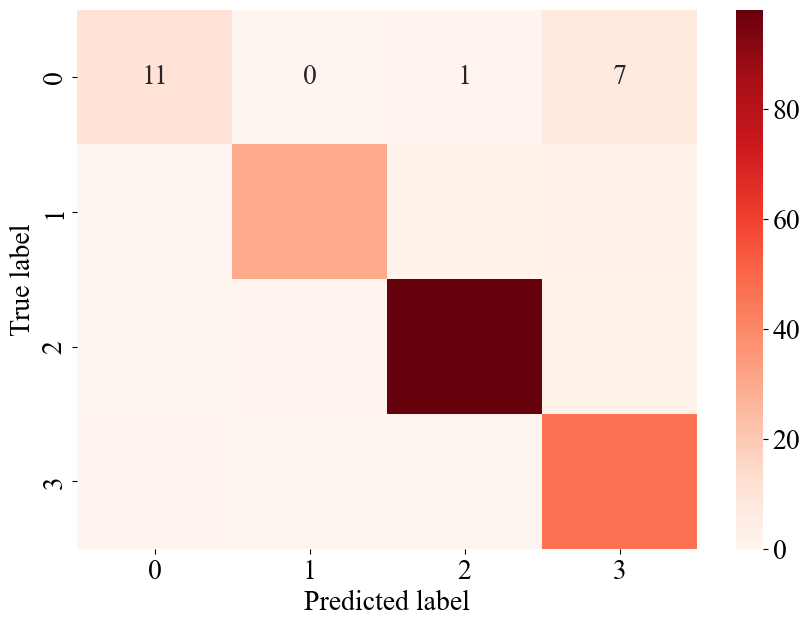


✅ 7. Confusion matrix plot generated.


In [7]:
# Only plot if evaluation is complete
if 'y_test' in locals() and 'y_pred' in locals():
    print("Generating confusion matrix plot...")
    
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Set font properties for the plot
    # (This ensures it looks correct when exported)
    plt.rcParams['font.sans-serif'] = ['Times New Roman']
    plt.rcParams['font.size'] = 20

    # Draw the heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, cmap='Reds', fmt='d') # fmt='d' ensures integer formatting
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    # Save the figure (optional)
    # plt.savefig('gbc_confusion_matrix.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    
    print("\n✅ 7. Confusion matrix plot generated.")
else:
    print("❌ 7. Plotting skipped. Please run evaluation first.")

In [8]:
# Only save if training is complete
if 'grid_search' in locals():
    # Save the best model (best_estimator_) found by Grid Search
    joblib.dump(grid_search.best_estimator_, MODEL_OUTPUT_PATH)
    
    print(f"Best model saved to: {MODEL_OUTPUT_PATH}")
    print("\n✅ 8. Final model saved to disk.")
else:
    print("❌ 8. Model saving skipped. Please run training first.")

Best model saved to: gradient_boosting_model_best.pkl

✅ 8. Final model saved to disk.
